# Basic Usage:
In this notebook you will find:
- How to get a survival curve and neighbors prediction using xgbse
- How to validate your xgbse model using sklearn

## Metrabic

We will be using the Molecular Taxonomy of Breast Cancer International Consortium (METABRIC) dataset from [pycox](https://github.com/havakv/pycox#datasets) as base for this example.

In [1]:
from xgbse.converters import convert_to_structured
from pycox.datasets import metabric
import numpy as np

# getting data
df = metabric.read_df()

df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
2,5.920251,6.776564,12.431715,5.873857,0.0,1.0,0.0,1.0,48.439999,140.233337,0
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1


## Split and Time Bins

Split the data in train and test, using sklearn API. We also setup the TIME_BINS array, which will be used to fit the survival curve

In [2]:
from xgbse.converters import convert_to_structured
from sklearn.model_selection import train_test_split

# splitting to X, T, E format
X = df.drop(['duration', 'event'], axis=1)
T = df['duration']
E = df['event']
y = convert_to_structured(T, E)

# splitting between train, and validation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state = 0)
TIME_BINS = np.arange(15, 315, 15)
TIME_BINS

array([ 15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180, 195,
       210, 225, 240, 255, 270, 285, 300])

## Fit and Predict

We will be using the DebiasedBCE estimator to fit the model and predict a survival curve for each point in our test data

In [3]:
from xgbse import XGBSEDebiasedBCE

# fitting xgbse model
xgbse_model = XGBSEDebiasedBCE()
xgbse_model.fit(X_train, y_train, time_bins=TIME_BINS)

# predicting
y_pred = xgbse_model.predict(X_test)

print(y_pred.shape)
y_pred.head()

(635, 20)


,15,30,45,60,75,90,105,120,135,150,165,180,195,210,225,240,255,270,285,300
0,0.983502,0.951852,0.923277,0.900028,0.862270,0.799324,0.715860,0.687257,0.651314,0.610916,0.568001,0.513172,0.493194,0.430701,0.377675,0.310496,0.272169,0.225599,0.184878,0.144089
1,0.973506,0.917739,0.839154,0.710431,0.663119,0.558886,0.495204,0.364995,0.311628,0.299939,0.226226,0.191373,0.171697,0.144864,0.112447,0.089558,0.081137,0.057679,0.048563,0.035985
2,0.986894,0.959209,0.919768,0.889910,0.853239,0.777208,0.725381,0.649177,0.582569,0.531787,0.485275,0.451667,0.428899,0.386413,0.344369,0.279685,0.242064,0.187967,0.158121,0.118562
3,0.986753,0.955210,0.910354,0.857684,0.824301,0.769262,0.665805,0.624934,0.583592,0.537261,0.493957,0.443193,0.416702,0.376552,0.308947,0.237033,0.177140,0.141838,0.117917,0.088937
4,0.977348,0.940368,0.873695,0.804796,0.742655,0.632426,0.556008,0.521490,0.493577,0.458477,0.416363,0.391099,0.364431,0.291472,0.223758,0.190398,0.165911,0.120061,0.095512,0.069566


mean predicted survival curve for test data

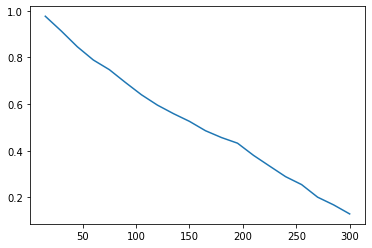

In [4]:
y_pred.mean().plot.line();

## Neighbors

We can also use our model for querying comparables based on survivability.

In [5]:
neighbors = xgbse_model.get_neighbors(
    query_data = X_test,
    index_data = X_train,
    n_neighbors = 5
)

print(neighbors.shape)
neighbors.head(5)

(635, 5)


,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5
829,339,166,508,1879,418
670,1846,1082,1297,194,1448
1064,416,1230,739,1392,589
85,1558,8,1080,613,1522
1814,105,859,1743,50,566


<b>example</b>: selecting a data point from query data (X_test) and checking its features

In [6]:
desired = neighbors.iloc[10]

X_test.loc[X_test.index == desired.name]

,x0,x1,x2,x3,x4,x5,x6,x7,x8
399,5.572504,7.367552,11.023443,5.406307,1.0,0.0,0.0,1.0,67.620003


... and finding its comparables from index data (X_train)

In [7]:
X_train.loc[X_train.index.isin(desired.tolist())]

,x0,x1,x2,x3,x4,x5,x6,x7,x8
757,5.745395,8.178815,10.745699,5.530381,1.0,1.0,0.0,1.0,64.930000
726,5.635854,6.648942,10.889588,5.496374,1.0,1.0,0.0,1.0,70.860001
968,5.541239,7.058089,10.463409,5.396433,1.0,0.0,0.0,1.0,71.070000
870,5.605712,7.309217,10.935708,5.542732,0.0,1.0,0.0,1.0,71.470001
1640,5.812605,7.646811,10.952687,5.516386,1.0,1.0,0.0,1.0,68.559998


## Score metrics

XGBSE implements concordance index and integrated brier score, both can be used to evaluate model performance

In [8]:
# importing metrics
from xgbse.metrics import concordance_index, approx_brier_score

# running metrics
print(f"C-index: {concordance_index(y_test, y_pred)}")
print(f"Avg. Brier Score: {approx_brier_score(y_test, y_pred)}")

C-index: 0.6706453426714781
Avg. Brier Score: 0.17221909077845754


## Cross Validation

We can also use sklearn's cross_val_score and make_scorer to cross validate our model

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

results = cross_val_score(xgbse_model, X, y, scoring=make_scorer(approx_brier_score))
results

array([0.16269636, 0.14880423, 0.12848939, 0.15335356, 0.15394174])